In [1]:
import logging
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from src.simulation import *
from src.rl import InverterEnv

logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [7]:

complete_series_csv = '../data/complete_series.csv'
df = pd.read_csv(complete_series_csv, parse_dates=['timestamp'])
prod_sim = EnergySim(max_step=7200, power_series=df.production_w)
cons_sim = EnergySim(max_step=6000, power_series=df.consumption_w, energy_type="consumption")
battery_wear_rate = 0
batt_sim = BatterySim(
    max_charge_rate=5000,
    max_discharge_rate=5000,
    capacity=10000,
    battery_wear_rate=battery_wear_rate,
    current_charge=10000
)
grid_sim = GridSim(
    feed_in_max=3500,
    feed_in_min=0,
    voltage_max=250,
    voltage_min=230,
    max_taken_from=6000,
    energy_price_sell=.1 / 1000,
    energy_price_buy=.4 / 1000,
    voltage_series=df.grid_voltage
)

inverter_sim = InverterSim(
    prod_sim=prod_sim,
    cons_sim=cons_sim,
    batt_sim=batt_sim,
    grid_sim=grid_sim,
    timestamps=df.timestamp.to_list(),
)
env = InverterEnv(inverter_sim, full_period)

In [8]:
def test_plot(env, steps=300, model=None):
    state_history = []
    obs, _ = env.reset()
    for _ in range(steps):
        action = 1
        if model:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)

        state = list(env.state[:])
        state = state + list(env.calc_reward())
        state_history.append(state)
        if done:
            break
    state_df = pd.DataFrame(
        state_history,
        columns=[
            'production_energy',
            'consumption_energy',
            'battery_charged_energy',
            'battery_discharged_energy',
            'battery_stored_energy',
            'grid_feed_energy',
            'grid_taken_energy',
            'production_energy_24_last',
            'consumption_energy_24_last',
            'production_energy_24_next',
            'consumption_energy_24_next',
            'production_energy_24_next_skip',
            'consumption_energy_24_next_skip',
            'timestep_sin',
            'timestep_cos',
            'reward',
            'feed_in_reward',
            'purchase_penalty',
            'battery_wear_penalty'
        ]
    )

    print(
        f"{sum(state_df.reward):.1f}="
        f"{sum(state_df.feed_in_reward):.1f}"
        f"-{sum(state_df.purchase_penalty) :.1f}"
        f"-{sum(state_df.battery_wear_penalty):.1f}"
    )
    state_df.reward = state_df.reward * 40
    state_df = state_df[[
        #         'production_energy',
        #         'consumption_energy',
        #         'battery_charged_energy',
        #         'battery_discharged_energy',
        'battery_stored_energy',
        #         'grid_feed_energy',
        #         'grid_taken_energy',
        #             'production_energy_24_last',
        #             'consumption_energy_24_last',
        'production_energy_24_next',
        'consumption_energy_24_next',
        'production_energy_24_next_skip',
        'consumption_energy_24_next_skip',
        'timestep_sin',
        'timestep_cos',
        'reward'
    ]]
    plt.figure(figsize=(12, 8))
    for column in state_df.columns:
        plt.plot(state_df[column], label=column)
    plt.xlabel('Time Step')
    plt.ylabel('State Value')
    plt.legend()
    plt.title('State Evolution over Time Steps')
    plt.show()


In [9]:
class ConservativeModel:
    def predict(self, obs, *args, **kwargs):
        action = 1
        return action, {}


class GreedyModel:
    def predict(self, obs, *args, **kwargs):
        action = 0
        return action, {}


class SimpleModel:
    def __init__(self, lowerbound, upperbound):
        self.lowerbound = lowerbound
        self.upperbound = upperbound

    def predict(self, obs, *args, **kwargs):
        sin, cos = (obs[-2:] - .5) * 2
        timestep = np.arctan2(sin, cos) / np.pi / 2 * 288
        timestep = int(timestep if timestep > 0 else timestep + 288)
        action = 0 if timestep > self.lowerbound and timestep < self.upperbound else 1
        return action, {}

227.3=270.7-43.4-0.0


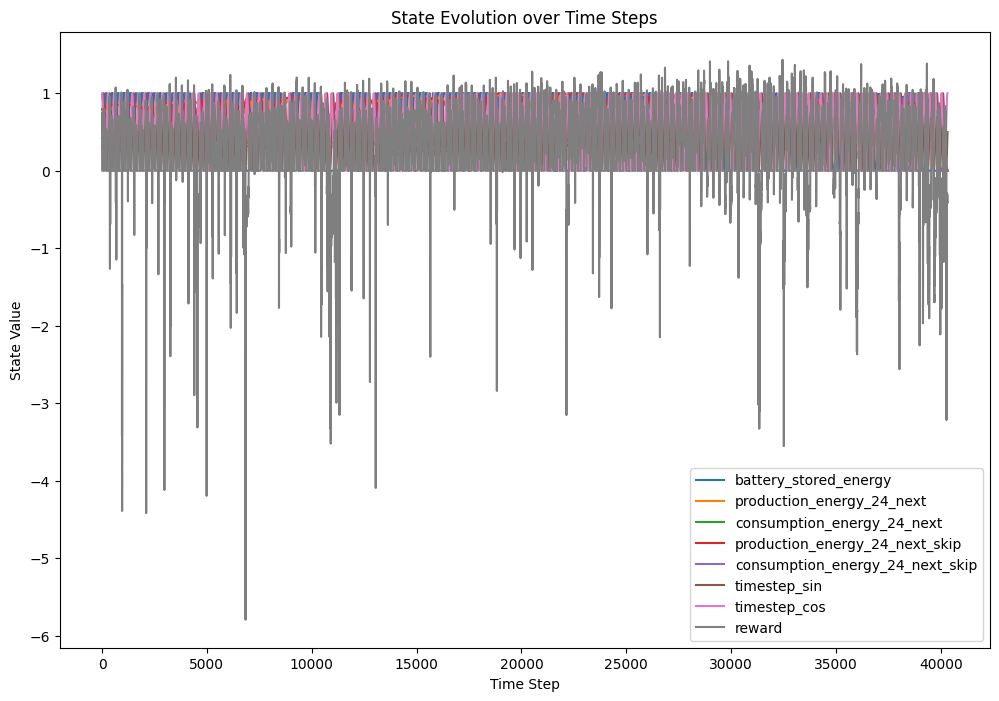

In [11]:
env.max_steps = full_period

test_plot(
    env,
    full_period,
        # week,
    #     GreedyModel(),
    #     ConservativeModel(),
    SimpleModel(60, 210),
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
254.1=266.1-12.0-0.0


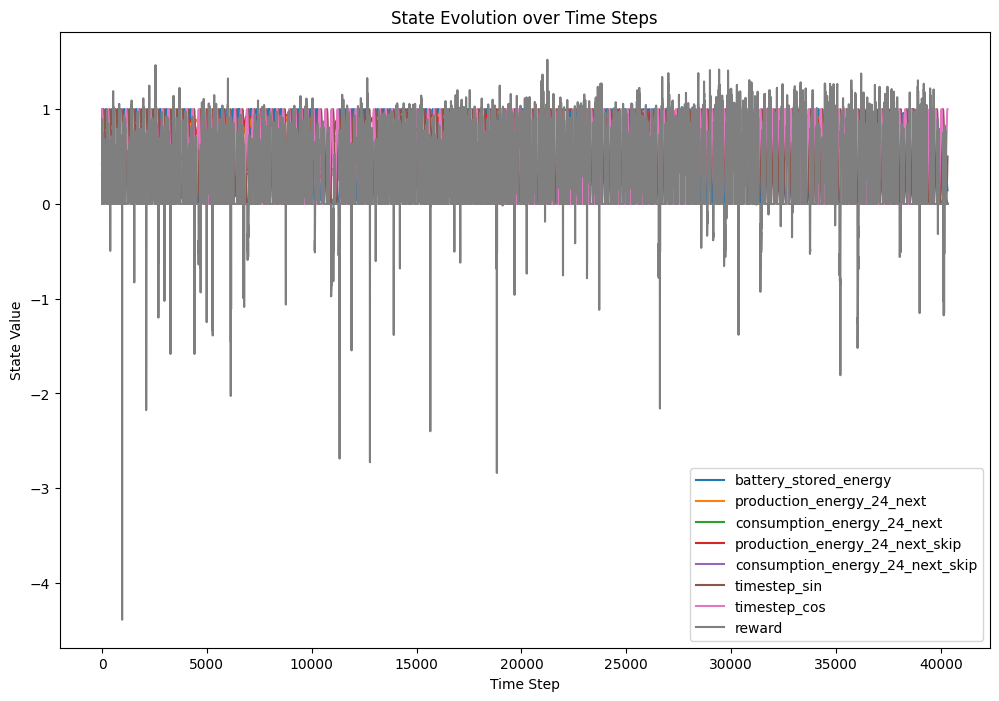

In [16]:
model = PPO.load(
    "../logs/models/ppo_inverter_best_15",
    env=env
)
test_plot(
    env,
    full_period,
    #     week,
    model
)

In [ ]:
# check_env(env)
# model = PPO(
#     "MlpPolicy", 
#     env, 
#     verbose=1,
#     ent_coef=0.01, 
#     learning_rate=0.0003, 
#     batch_size=2048,
# )

In [ ]:
# model = PPO.load("ppo_inverter", env=env,verbose=1)
# env.reset()
# model.learn(total_timesteps=1000000)
# model.save("ppo_inverter")

In [ ]:
# env.max_steps=10000
# model = PPO.load(
#     "ppo_inverter", 
#     env=SubprocVecEnv([lambda: env] * 20),
#     verbose=1
# )
# model.learn(total_timesteps=5000000)
# model.save("ppo_inverter")

In [ ]:
env.max_steps = full_period

# multi_env=SubprocVecEnv([lambda: env] * 20)
# train_env=multi_env
train_env = env

eval_callback = EvalCallback(
    train_env,
    best_model_save_path="./logs/best_model",
    log_path="./logs/results",
    eval_freq=full_period * 5,
    deterministic=True,
    render=False,
    verbose=1
)

model = PPO.load(
    "/kaggle/input/ppo-inverter/ppo_inverter_best_15",
    env=train_env,
    verbose=0
)

model.learn(
    total_timesteps=full_period * 5 * 100,
    callback=eval_callback
)

In [ ]:
# model.save("ppo_inverter")

In [ ]:
model = PPO.load(
    #     "/kaggle/input/ppo-inverter/ppo_inverter_best_15",
    "/kaggle/working/logs/best_model/best_model.zip",
    env=env
)
test_plot(
    env,
    full_period,
    #     week,
    model
)

In [ ]:
# model = PPO.load(
#     "/kaggle/input/ppo-inverter/ppo_inverter_best_17",
#     #     "./logs/best_model", 
#     env=env
# )
# test_plot(
#     env,
#     full_period,
#     model
# )